<a href="https://colab.research.google.com/github/09aryan/MEME_CLASSIFICATION_USING_SENTIMENT_ANALYSIS/blob/main/Meme_Classification_using_random%2Cknn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#   Importing all the necessary libraries/modules.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import skimage.io as io
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True    #   To avoid errors while loading truncated images.
from PIL import Image
import re
!pip install pytesseract
import pytesseract
import pickle

## **Classification:**

### **‣   Image Classification:**

##### **•   Reading the data:**

In [ ]:
dataframe=pd.read_csv("/content/labels.csv") #   Reading the data from the specified CSV (.csv) file.
dataframe=dataframe.drop(dataframe.columns[0], axis=1)  #   Dropping the first column of the dataframe.
dataframe["overall_sentiment"]=dataframe["overall_sentiment"].map({"neutral":0, "positive":1, "very_positive":2, "negative":3, "very_negative":4})    #   Assigning numerical values to the image sentiments.
dataframe=dataframe.sort_values(by=["overall_sentiment"], ascending=True)
dataframe=dataframe.reset_index(drop=True)  #   Resetting the index of the pandas.DataFrame.
dataframe

,image_name,text_ocr,text_corrected,overall_sentiment
0,image_1311.jpg,THAT MOMENT YOU REALIZE USE THIS WAS A REALLY ...,THAT MOMENT YOU REALIZE USE THIS WAS A REALLY ...,0
1,image_1664.jpg,THE FACE YOU MAKE WHEN YOU MEET HER EX PUUSLIW...,THE FACE YOU MAKE WHEN YOU MEET HER EX PUUSLIW...,0
2,image_5509.jpg,Me in 2011 small issues offhandedly dismissed ...,Me in 2011 small issues offhandedly dismissed ...,0
3,image_1666.jpg,WEALTHY KNIGHT THAT COULD HAVE ANY WOMAN? FUCK...,WEALTHY KNIGHT THAT COULD HAVE ANY WOMAN? FUCK...,0
4,image_1669.jpg,WHAT YOU THINK YOU LOOK LIKE FLIRTING WITH YOU...,WHAT YOU THINK YOU LOOK LIKE FLIRTING WITH YOU...,0
...,...,...,...,...
6987,image_4076.jpg,YOU GET TO EAT FOOD EVERYDAY?! quickmeme.com,YOU GET TO EAT FOOD EVERYDAY?! quickmeme.com,4
6988,image_5871.jpg,"DATHI WHAT IS WITH ""HER NECK ANYWAY? imgflip.com","DATHI WHAT IS WITH ""HER NECK ANYWAY? imgflip.com",4
6989,image_3622.jpg,DONT TREAT WOMEN LIKE OBJECTS OBJECTS ARE USEF...,DONT TREAT WOMEN LIKE OBJECTS OBJECTS ARE USEF...,4
6990,image_5451.jpeg,THIS IS THE I'M WHITE,"THIS IS THE I'M WHITE BUT MY KIDS WONT BE""HAIRDO",4


##### **•   Determining if there's an imbalance between classes:**

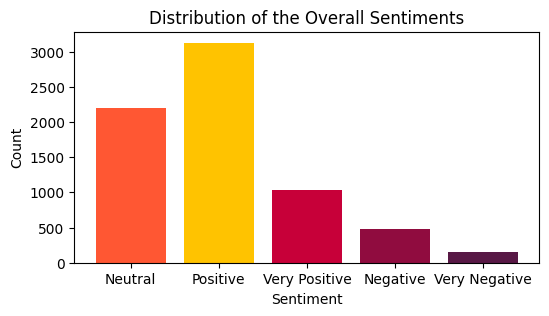

In [ ]:
dataframe["overall_sentiment"].value_counts()   #   Finding the count of each sentiment in the pandas.DataFrame.

#   Plotting the distribution of the image sentiments.

plt.figure(figsize=(6, 3))
plt.bar(dataframe["overall_sentiment"].value_counts().index, dataframe["overall_sentiment"].value_counts().values, color=["#FFC300", "#FF5733", "#C70039", "#900C3F", "#581845"])
plt.xticks(dataframe["overall_sentiment"].value_counts().index, ["Positive", "Neutral", "Very Positive", "Negative", "Very Negative"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of the Overall Sentiments")
plt.show()

##### **•   Balancing the imbalanced classes:**

In [ ]:
#   Separating the majority and minority classes.

dataframe_majority=dataframe[dataframe["overall_sentiment"]==1]
dataframe_minority=dataframe[dataframe["overall_sentiment"]!=1]

dataframe_minority_upsampled=resample(dataframe_minority, replace=True, n_samples=len(dataframe_majority), random_state=42) #   Resampling the minority class with replacement.
dataframe_upsampled=pd.concat([dataframe_majority, dataframe_minority_upsampled])   #   Concatenating the majority and minority class pandas.DataFrames.
dataframe_upsampled=dataframe_upsampled.sort_values(by=["overall_sentiment"], ascending=True)   #   Sorting the pandas.DataFrame by the overall sentiment.
dataframe_upsampled=dataframe_upsampled.reset_index(drop=True)  #   Resetting the index of the pandas.DataFrame.
dataframe_upsampled["overall_sentiment"].value_counts() #   Finding the frequencies of each sentiment in the pandas.DataFrame.

1    3127
0    1784
2     837
3     398
4     108
Name: overall_sentiment, dtype: int64

##### **•   Extracting the images from the specified directory in order of their sentiments:**

In [ ]:
# !mkdir -p /content/drive/MyDrive/images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#   Extracting the images from the specified directory in order of their sentiments, and storing them in a list.

images=[]
for i in range(len(dataframe_upsampled)):
    image=io.imread("drive/MyDrive/images/"+dataframe_upsampled["image_name"][i])
    images.append(image)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


##### **•   Pre-processing the data:**

In [ ]:
#   Splitting the image data into training and testing sets.

train_images, test_images, train_labels, test_labels=train_test_split(images, dataframe_upsampled["overall_sentiment"], test_size=0.2, random_state=42)

#   Converting the training images to greyscale and resizing them to (200 x 200) pixels.

x_train=[]
for i in range(len(train_images)):
    x_train.append(np.array(Image.fromarray(train_images[i]).convert("L").resize((200, 200))))

#   Converting the testing images to greyscale and resizing them to (200 x 200) pixels.

x_test=[]
for i in range(len(test_images)):
    x_test.append(np.array(Image.fromarray(test_images[i]).convert("L").resize((200, 200))))

#   Normalising the training and testing image data.

x_train=np.array(x_train)/255.0
x_test=np.array(x_test)/255.0

#   Reshaping the training and testing image data to two-dimensional arrays.

nsamples, nx, ny=x_train.shape
x_train=x_train.reshape((nsamples, nx*ny))

nsamples, nx, ny=x_test.shape
x_test=x_test.reshape((nsamples, nx*ny))

##### **•   Images after pre-processing:**

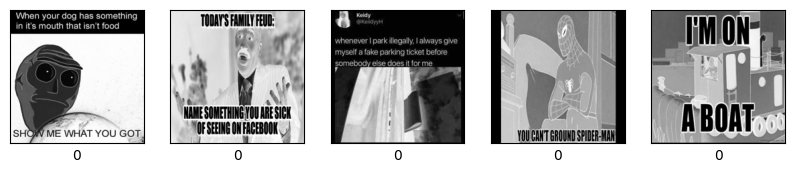

In [ ]:
#   Plotting a few images from the training set after pre-processing.

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((200, 200)), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

##### **•   Scaling the data:**

In [ ]:
#   Scaling the training and testing sets.

ss=StandardScaler() #   Creating an instance of the StandardScaler class.
x_train=ss.fit_transform(x_train)   #   Fitting the instance of the StandardScaler class to the training set and transforming it.
x_test=ss.transform(x_test) #   Transforming the testing set.

#### **-   Random Forest Classifier:**

In [ ]:
rf=RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=42)   #   Creating an instance of the RandomForestClassifier class.
rf.fit(x_train, train_labels)   #   Training the model on the training data.

RandomForestClassifier(criterion='entropy', random_state=42)

##### **•   Predicting the labels for the classification model:**

In [ ]:
rf_predictions=rf.predict(x_test)   #   Predicting the labels of the testing images.
rf_predictions

array([1, 0, 1, ..., 1, 1, 1])

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [ ]:
rf_score=accuracy_score(test_labels, rf_predictions)    #   Calculating the accuracy of the model.
rf_f1_score=f1_score(test_labels, rf_predictions, average="macro")  #   Calculating the average macro F1-score of the model.
print(classification_report(test_labels, rf_predictions))   #   Printing the classification report of the model.
print("Accuracy: ", rf_score*100, "%")
print("F1-Score (Macro): ", rf_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.96      0.49      0.65       374
           1       0.65      0.99      0.79       617
           2       1.00      0.54      0.70       164
           3       1.00      0.37      0.54        78
           4       1.00      0.39      0.56        18

    accuracy                           0.73      1251
   macro avg       0.92      0.56      0.65      1251
weighted avg       0.82      0.73      0.72      1251

Accuracy:  73.38129496402878 %
F1-Score (Macro):  64.70241035465688 %


##### **•   Displaying the confusion matrix for the classification model:**

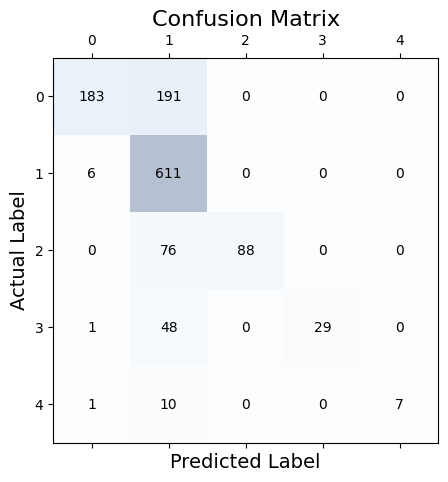

In [ ]:
confusion_matrix_rf=confusion_matrix(test_labels, rf_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_rf, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_rf.shape[0]):
    for j in range(confusion_matrix_rf.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_rf[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

#### **-   K-Nearest Neighbours Classifier:**

In [ ]:
knc=KNeighborsClassifier(n_neighbors=90, weights="distance", metric="minkowski", p=1)   #   Creating an instance of the KNeighborsClassifier class.
knc.fit(x_train, train_labels)  #   Training the model on the training data.

KNeighborsClassifier(n_neighbors=90, p=1, weights='distance')

##### **•   Predicting the labels for the classification model:**

In [ ]:
knc_predictions=knc.predict(x_test)   #   Predicting the labels of the testing images.
knc_predictions

array([1, 0, 1, ..., 1, 1, 1])

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [ ]:
knc_score=accuracy_score(test_labels, knc_predictions)    #   Calculating the accuracy of the model.
knc_f1_score=f1_score(test_labels, knc_predictions, average="macro")  #   Calculating the average macro F1-score of the model.
print(classification_report(test_labels, knc_predictions))  #   Printing the classification report of the model.
print("Accuracy: ", knc_score*100, "%")
print("F1-Score (Macro): ", knc_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.98      0.49      0.65       374
           1       0.65      1.00      0.79       617
           2       1.00      0.53      0.69       164
           3       1.00      0.37      0.54        78
           4       1.00      0.39      0.56        18

    accuracy                           0.74      1251
   macro avg       0.93      0.56      0.65      1251
weighted avg       0.82      0.74      0.72      1251

Accuracy:  73.621103117506 %
F1-Score (Macro):  64.74326535445296 %


##### **•   Displaying the confusion matrix for the classification model:**

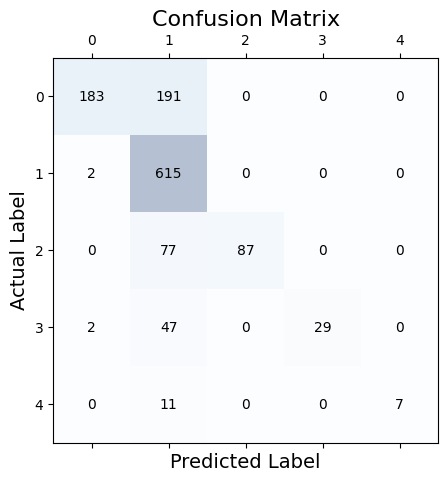

In [ ]:
confusion_matrix_knc=confusion_matrix(test_labels, knc_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_knc, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_knc.shape[0]):
    for j in range(confusion_matrix_knc.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_knc[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

#### **-    Extra Trees Classifier:**

In [ ]:
etc=ExtraTreesClassifier(n_estimators=100, random_state=42) #   Creating an instance of the ExtraTreesClassifier class.
etc.fit(x_train, train_labels)  #   Training the model on the training data.

ExtraTreesClassifier(random_state=42)

##### **•   Predicting the labels for the classification model:**

In [ ]:
etc_predictions=etc.predict(x_test) #   Predicting the labels of the testing images.
etc_predictions

array([1, 0, 1, ..., 1, 1, 1])

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [ ]:
etc_score=accuracy_score(test_labels, etc_predictions)    #   Calculating the accuracy of the model.
etc_f1_score=f1_score(test_labels, etc_predictions, average="macro")  #   Calculating the average macro F1-score of the model.
print(classification_report(test_labels, etc_predictions))  #   Printing the classification report of the model.
print("Accuracy: ", etc_score*100, "%")
print("F1-Score (Macro): ", etc_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.93      0.49      0.64       374
           1       0.65      0.99      0.79       617
           2       0.99      0.53      0.69       164
           3       1.00      0.37      0.54        78
           4       1.00      0.39      0.56        18

    accuracy                           0.73      1251
   macro avg       0.92      0.55      0.64      1251
weighted avg       0.81      0.73      0.71      1251

Accuracy:  73.06155075939249 %
F1-Score (Macro):  64.40334488325429 %


##### **•   Displaying the confusion matrix for the classification model:**

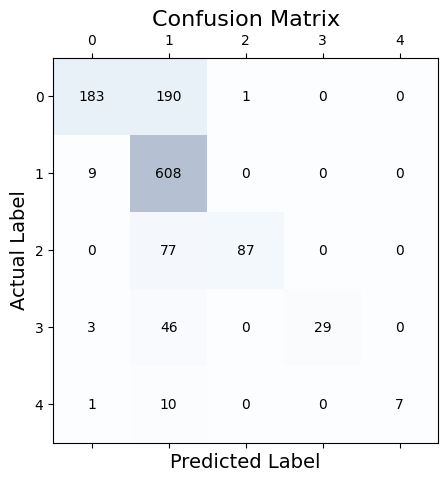

In [ ]:
confusion_matrix_etc=confusion_matrix(test_labels, etc_predictions) #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_etc, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_etc.shape[0]):
    for j in range(confusion_matrix_etc.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_etc[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

##### **•   Testing the most accurate classification model against a custom image (meme):**

Image:


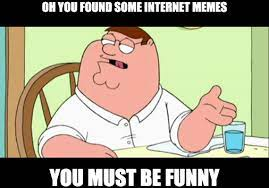

In [ ]:
image_path="/content/drive/MyDrive/test_images/download.jpg"   #   Path of the image to be tested.
image=Image.open(image_path)    #   Opening the image.
print("Image:")
image

In [ ]:
image=image.convert("L")    #   Converting the image to grayscale.
image=image.resize((200, 200))  #   Resizing the image to (200 x 200) pixels.
image=np.array(image)   #   Converting the image to a NumPy.Array.
image=np.array(image)/255.0 #   Normalising the image.
nx, ny=image.shape  #   Retrieving the dimensions of the image.
image=image.reshape((1, nx*ny)) #   Reshaping the image to a one-dimensional array.
classes=["neutral", "positive", "very_positive", "negative", "very_negative"]   #   Defining a list of all the classes.
answer=knc.predict(image)  #   Predicting the label of the image.
print("Predicted:", classes[answer[0]])

Predicted: positive


### **‣ Text Classification:**

##### **•   Reading the data (again):**

In [ ]:
dataframe=pd.read_csv("labels.csv") #   Reading the data from the specified CSV (.csv) file.
dataframe=dataframe.drop(dataframe.columns[0], axis=1)  #   Dropping the first column of the dataframe.
dataframe["overall_sentiment"]=dataframe["overall_sentiment"].map({"neutral":0, "positive":1, "very_positive":2, "negative":3, "very_negative":4})    #   Assigning numerical values to the image sentiments.
dataframe=dataframe.sort_values(by=["overall_sentiment"], ascending=True)
dataframe=dataframe.reset_index(drop=True)  #   Resetting the index of the pandas.DataFrame.
dataframe

,image_name,text_ocr,text_corrected,overall_sentiment
0,image_1311.jpg,THAT MOMENT YOU REALIZE USE THIS WAS A REALLY ...,THAT MOMENT YOU REALIZE USE THIS WAS A REALLY ...,0
1,image_1664.jpg,THE FACE YOU MAKE WHEN YOU MEET HER EX PUUSLIW...,THE FACE YOU MAKE WHEN YOU MEET HER EX PUUSLIW...,0
2,image_5509.jpg,Me in 2011 small issues offhandedly dismissed ...,Me in 2011 small issues offhandedly dismissed ...,0
3,image_1666.jpg,WEALTHY KNIGHT THAT COULD HAVE ANY WOMAN? FUCK...,WEALTHY KNIGHT THAT COULD HAVE ANY WOMAN? FUCK...,0
4,image_1669.jpg,WHAT YOU THINK YOU LOOK LIKE FLIRTING WITH YOU...,WHAT YOU THINK YOU LOOK LIKE FLIRTING WITH YOU...,0
...,...,...,...,...
6987,image_4076.jpg,YOU GET TO EAT FOOD EVERYDAY?! quickmeme.com,YOU GET TO EAT FOOD EVERYDAY?! quickmeme.com,4
6988,image_5871.jpg,"DATHI WHAT IS WITH ""HER NECK ANYWAY? imgflip.com","DATHI WHAT IS WITH ""HER NECK ANYWAY? imgflip.com",4
6989,image_3622.jpg,DONT TREAT WOMEN LIKE OBJECTS OBJECTS ARE USEF...,DONT TREAT WOMEN LIKE OBJECTS OBJECTS ARE USEF...,4
6990,image_5451.jpeg,THIS IS THE I'M WHITE,"THIS IS THE I'M WHITE BUT MY KIDS WONT BE""HAIRDO",4


##### **•   Balancing the imbalanced classes:**

In [ ]:
#   Separating the majority and minority classes.

dataframe_majority=dataframe[dataframe["overall_sentiment"]==1]
dataframe_minority=dataframe[dataframe["overall_sentiment"]!=1]

dataframe_minority_upsampled=resample(dataframe_minority, replace=True, n_samples=len(dataframe_majority), random_state=42) #   Resampling the minority class with replacement.
dataframe_upsampled=pd.concat([dataframe_majority, dataframe_minority_upsampled])   #   Concatenating the majority and minority class pandas.DataFrames.
dataframe_upsampled=dataframe_upsampled.sort_values(by=["overall_sentiment"], ascending=True)   #   Sorting the pandas.DataFrame by the overall sentiment.
dataframe_upsampled=dataframe_upsampled.reset_index(drop=True)  #   Resetting the index of the pandas.DataFrame.
dataframe_upsampled["overall_sentiment"].value_counts() #   Finding the frequencies of each sentiment in the pandas.DataFrame.

1    3127
0    1784
2     837
3     398
4     108
Name: overall_sentiment, dtype: int64

##### **•   Applying one-hot encoding to the image sentiments:**

In [ ]:
ohe_dataframe=pd.get_dummies(dataframe_upsampled, columns=["overall_sentiment"])    #   Converting all the categorical variables into numerical/dummy variables.
ohe_dataframe

,image_name,text_ocr,text_corrected,overall_sentiment_0,overall_sentiment_1,overall_sentiment_2,overall_sentiment_3,overall_sentiment_4
0,image_6455.jpg,I just want someone to look at me the way Bill...,I just want someone to look at me the way Bill...,1,0,0,0,0
1,image_4616.png,Deadpool had a daughter named Eleanor,Deadpool had a daughter named Eleanor but Dea...,1,0,0,0,0
2,image_5382.png,HOW I ROLL OUT OF BED IN THE MORNING,HOW I ROLL OUT OF BED IN THE MORNING,1,0,0,0,0
3,image_6198.png,"<html><head><meta content=""text/html; charset=...",HE DOESN'T ASK GOOGLE GOOGLE ASKS HIM! CHUCK....,1,0,0,0,0
4,image_4473.png,WHEN CHUCK NORRIS LEFT FOR COLLEGE HE TOLD HIS...,WHEN CHUCK NORRIS LEFT FOR COLLEGE HE TOLD HIS...,1,0,0,0,0
...,...,...,...,...,...,...,...,...
6249,image_5298.jpg,First,"First I was like ""Hodor..."" But then I was a...",0,0,0,0,1
6250,image_2750.jpeg,When you're about to be drafted into the milit...,When you're about to be drafted into the milit...,0,0,0,0,1
6251,image_3619.jpg,When you unplug your dying grandpa to charge y...,When you unplug your dying grandpa to charge y...,0,0,0,0,1
6252,image_1995.png,HILLARY GETS CAUGHT IN NON-STOP CORRUPTION SCA...,HILLARY GETS CAUGHT IN NON-STOP CORRUPTION SCA...,0,0,0,0,1


##### **•   Pre-processing the data:**

In [ ]:
import nltk
nltk.download('stopwords')
vectorizer=TfidfVectorizer(max_features=1000, stop_words=stopwords.words("english"), ngram_range=(1, 2))    #   Creating an instance of the TfidfVectorizer class.
x=vectorizer.fit_transform(ohe_dataframe["text_corrected"].values.astype("U"))    #   Creating a bag of words model.
y=ohe_dataframe[["overall_sentiment_0", "overall_sentiment_1", "overall_sentiment_2", "overall_sentiment_3", "overall_sentiment_4"]].values
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)    #   Splitting the data into training and testing data.

#   Converting the one-hot encoded labels into a one-dimensional array.

y_train=np.argmax(y_train, axis=1)
y_test=np.argmax(y_test, axis=1)

#   Converting the sparse matrices into dense matrices.

x_train=x_train.toarray()
x_test=x_test.toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### **-    Stochastic Gradient Descent Classifier:**

In [ ]:
sgd=SGDClassifier(loss="perceptron", penalty="l2", max_iter=100000, random_state=42, n_jobs=-1)    #   Creating an instance of the SGDClassifier class.
sgd.fit(x_train, y_train)   #   Training the model.

SGDClassifier(loss='perceptron', max_iter=100000, n_jobs=-1, random_state=42)

##### **•   Predicting the labels for the classification model:**

In [ ]:
sgd_predictions=sgd.predict(x_test)   #   Predicting the labels of the testing data.
sgd_predictions

array([1, 1, 1, ..., 1, 1, 0])

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [ ]:
sgd_score=accuracy_score(y_test, sgd_predictions)    #   Calculating the accuracy of the model.
sgd_f1_score=f1_score(y_test, sgd_predictions, average="weighted")    #   Calculating the average weighted F1-score of the model.
print(classification_report(y_test, sgd_predictions))   #   Printing the classification report of the model.
print("Accuracy: ", sgd_score*100, "%")
print("F1-Score (Weighted): ", sgd_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.42      0.37      0.39       374
           1       0.53      0.72      0.61       617
           2       0.41      0.18      0.25       164
           3       0.47      0.09      0.15        78
           4       0.43      0.17      0.24        18

    accuracy                           0.50      1251
   macro avg       0.45      0.30      0.33      1251
weighted avg       0.48      0.50      0.46      1251

Accuracy:  49.5603517186251 %
F1-Score (Weighted):  46.45273990562543 %


##### **•   Displaying the confusion matrix for the classification model:**

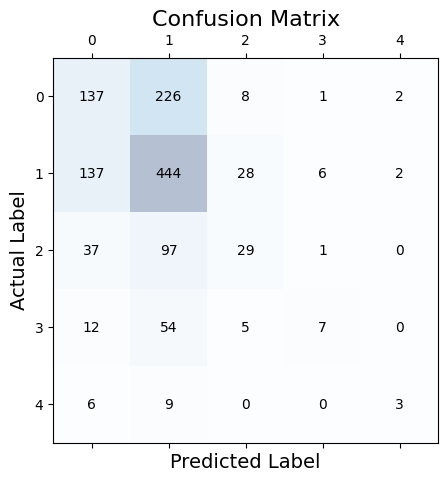

In [ ]:
confusion_matrix_sgd=confusion_matrix(y_test, sgd_predictions) #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_sgd, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_sgd.shape[0]):
    for j in range(confusion_matrix_sgd.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_sgd[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

#### **-    Multinomial Naïve Bayes Classifier:**

In [ ]:
mnb=MultinomialNB() #   Creating an instance of the MultinomialNB class.
mnb.fit(x_train, y_train)   #   Training the model on the training data.

MultinomialNB()

##### **•   Predicting the labels for the classification model:**

In [ ]:
mnb_predictions=mnb.predict(x_test)   #   Predicting the labels of the testing data.
mnb_predictions

array([1, 1, 1, ..., 1, 1, 1])

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [ ]:
mnb_score=accuracy_score(y_test, mnb_predictions)   #   Calculating the accuracy of the model.
mnb_f1_score=f1_score(y_test, mnb_predictions, average="weighted")   #   Calculating the average weighted F1-score of the model.
print(classification_report(y_test, mnb_predictions, zero_division=1))  #   Printing the classification report of the model.
print("Accuracy: ", mnb_score*100, "%")
print("F1-Score (Weighted): ", mnb_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.47      0.18      0.26       374
           1       0.51      0.91      0.66       617
           2       0.50      0.02      0.05       164
           3       1.00      0.00      0.00        78
           4       1.00      0.00      0.00        18

    accuracy                           0.51      1251
   macro avg       0.70      0.22      0.19      1251
weighted avg       0.54      0.51      0.41      1251

Accuracy:  50.83932853717026 %
F1-Score (Weighted):  40.887047738187924 %


##### **•   Displaying the confusion matrix for the classification model:**

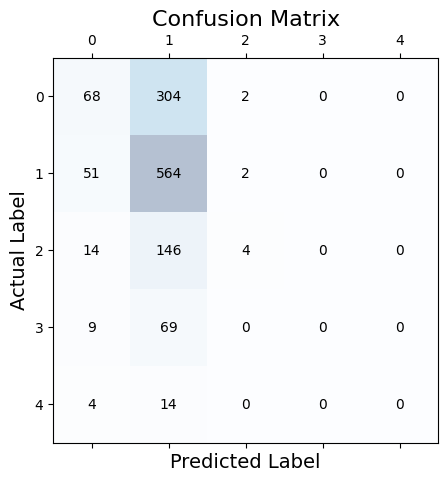

In [ ]:
confusion_matrix_mnb=confusion_matrix(y_test, mnb_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_mnb, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_mnb.shape[0]):
    for j in range(confusion_matrix_mnb.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_mnb[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

#### **-    Logistic Regression:**

In [ ]:
lr=LogisticRegression(solver="liblinear", max_iter=10000, class_weight="balanced", penalty="l2", dual=True) #   Creating an instance of the LogisticRegression class.
lr.fit(x_train, y_train)    #   Training the model on the training data.

LogisticRegression(class_weight='balanced', dual=True, max_iter=10000,
                   solver='liblinear')

##### **•   Predicting the labels for the classification model:**

In [ ]:
lr_predictions=lr.predict(x_test)   #   Predicting the labels of the testing data.
lr_predictions

array([2, 3, 1, ..., 1, 1, 2])

##### **•   Calculating the accuracy, and displaying the classification report for the classification model:**

In [ ]:
lr_score=accuracy_score(y_test, lr_predictions)   #   Calculating the accuracy of the model.
lr_f1_score=f1_score(y_test, lr_predictions, average="weighted")   #   Calculating the average weighted F1-score of the model.
print(classification_report(y_test, lr_predictions))    #   Printing the classification report of the model.
print("Accuracy: ", lr_score*100, "%")
print("F1-Score (Weighted): ", lr_f1_score*100, "%")

              precision    recall  f1-score   support

           0       0.46      0.33      0.38       374
           1       0.53      0.57      0.55       617
           2       0.30      0.32      0.31       164
           3       0.18      0.22      0.20        78
           4       0.16      0.44      0.23        18

    accuracy                           0.44      1251
   macro avg       0.32      0.38      0.33      1251
weighted avg       0.45      0.44      0.44      1251

Accuracy:  44.04476418864908 %
F1-Score (Weighted):  44.045748357289824 %


##### **•   Displaying the confusion matrix for the classification model:**

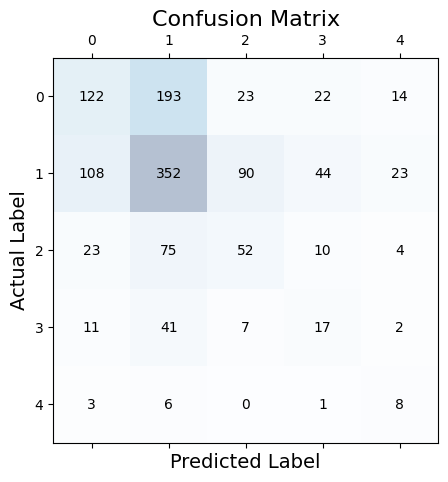

In [ ]:
confusion_matrix_lr=confusion_matrix(y_test, lr_predictions)   #   Creating a confusion matrix for the model.

#   Plotting the confusion matrix.

figure, axis=plt.subplots(figsize=(5, 5))
axis.matshow(confusion_matrix_lr, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix_lr.shape[0]):
    for j in range(confusion_matrix_lr.shape[1]):
        axis.text(x=j, y=i, s=confusion_matrix_lr[i, j], va="center", ha="center")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("Actual Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

##### **•   Calculating the average F1-score of all the analysed classification models:**

In [ ]:
#   Calculating the average F1-score of all the analyzed classification models.

f1_scores=[rf_f1_score, knc_f1_score, etc_f1_score, sgd_f1_score, mnb_f1_score, lr_f1_score]
print("Average F1-Score: ", sum(f1_scores)/len(f1_scores)*100, "%")

Average F1-Score:  54.20575943224455 %


##### **•   Testing the most accurate classification model against text extracted from a custom image (meme):**

Image:


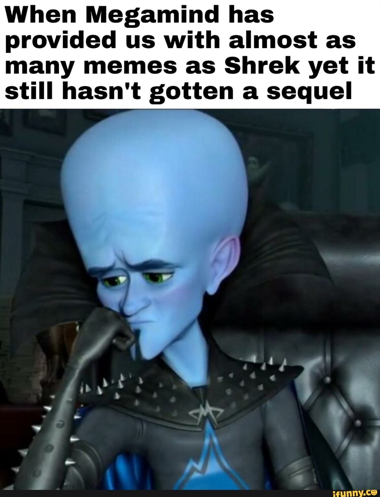

In [ ]:
image_path="/content/drive/MyDrive/test_images/meme.jpg"   #   Path of the image to be tested.
image=Image.open(image_path)    #   Opening the image.
image=image.resize((380, 497))  #   Resizing the image.
print("Image:")
image

### **‣ Comparison (Accuracy):**

##### **•   Plotting the accuracies of all six analysed machine learning classification models:**

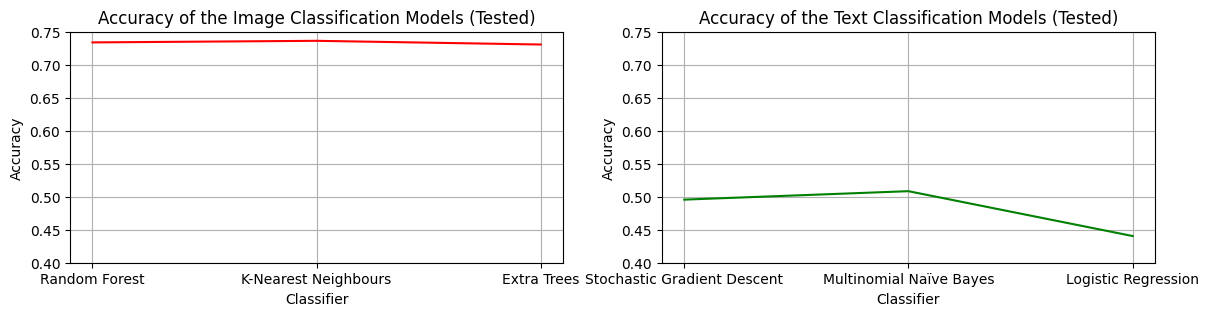

In [ ]:
#   Creating a subplot for the figures.

figure, axes=plt.subplots(1, 2, figsize=(14, 3))

#   Plotting the accuracy of the image and text classification models.

axes[0].plot(["Random Forest", "K-Nearest Neighbours", "Extra Trees"], [rf_score, knc_score, etc_score], color="red")
axes[1].plot(["Stochastic Gradient Descent", "Multinomial Naïve Bayes", "Logistic Regression"], [sgd_score, mnb_score, lr_score], color="green")

#   Setting the titles of the figures.

axes[0].set_title("Accuracy of the Image Classification Models (Tested)")
axes[1].set_title("Accuracy of the Text Classification Models (Tested)")

#   Setting the labels of the axes.

axes[0].set_xlabel("Classifier")
axes[1].set_xlabel("Classifier")
axes[0].set_ylabel("Accuracy")
axes[1].set_ylabel("Accuracy")

#   Setting the tick labels of the axes.

axes[0].set_xticks(["Random Forest", "K-Nearest Neighbours", "Extra Trees"])
axes[1].set_xticks(["Stochastic Gradient Descent", "Multinomial Naïve Bayes", "Logistic Regression"])
axes[0].set_yticks(np.arange(0.4, 0.8, 0.05))
axes[1].set_yticks(np.arange(0.4, 0.8, 0.05))

#   Adding a grid to the figures.

axes[0].grid()
axes[1].grid()

plt.show()

### **‣   Conclusion:**

##### **•   Exporting all the machine learning classification models:**

In [ ]:
#   Exporting all the machine learning classification models into separate pickle (.pkl) files.

pickle.dump(rf, open("rf_model.pkl", "wb"))
pickle.dump(knc, open("knc_model.pkl", "wb"))
pickle.dump(etc, open("etc_model.pkl", "wb"))
pickle.dump(sgd, open("sgd_model.pkl", "wb"))
pickle.dump(mnb, open("mnb_model.pkl", "wb"))
pickle.dump(lr, open("lr_model.pkl", "wb"))
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))